Polona in Ančka nista sami. Danes bomo delali z originalnimi podatki (za prajšnjo domačo nalogo so bili predelani v prijaznejšo obliko), kakršne dobimo na spletni strani [Movebank](https://www.movebank.org/cms/webapp?gwt_fragment=page=search_map), če poiščemo medvede in kliknemo na študijo, izvedeno v Sloveniji. Za potrebe domače naloge so podatki seveda že priloženi nalogi - so pa enaki, kot bi jih sami dobili na spletni strani.

**Ker se naloga ocenjuje, je pogoj za pristop k izpitu in jo morate narediti vsaj za oceno 6.**

Vse funkcije morajo biti napisane tako, kot da bi tabela lahko vsebovala druge podatke (drugačno število vrstic, drugačno število medvedov z drugimi imeni, datumi in lokacijami), smejo (in morajo) pa predpostaviti, da se stolpci imenujejo tako, kot v podani datoteki. Testi bodo tvojemu programu podtikali tudi drugačne podatke.

Kjer ni eksplicitno zahtevan numpy, lahko nalogo rešuješ, kakor želiš.

Ta naloga bo manj kaotična kot Miklavževa pisma. :) Podatki so lepši in edina funkcija, kjer bo malo zmede, je prva - zaradi zapletenega preračunavanja podakov.

## Ocena 6: Medo z Garminom

#### 1. Branje podatkov

Napiši funkcijo, `preberi_podatke()`, ki prebere podatke iz datoteke `"Brown bear Slovenia 1993-1999.csv"`, ki se nahaja v istem direktoriju kot program. Za branje podatkov lahko napišeš funkcijo ali ne; lahko uporabljaš `np.genfromtxt` (ali, kot se bo izkazalo, raje) primerno Pythonovo funkcijo za branje csv datotek.

Funkcija mora vrniti terko četverko s štirimi tabelami. Vse imajo toliko vrstic (oz. elementov, če so 1D), kolikor je meritev v datoteki.

- `imena` je vsebuje imena medvedov; konkretno, v tabelo prebereš stolpec `individual-local-identifier`.
- `datumi` ima tri stolpce, ki vsebujejo leto, mesec in dan posamične meritve, npr. `[1994, 4, 29]` za peto vrstico.
- `dnevi` ima en stolpec, ki vsebuje isti podatek v drugi obliki: namesto datumov vsebuje število dni od začetka študije. **Pri tem ignorirajte ure dneva**: 23. maj ob 00:01 je en dan kasneje kot 22. maj ob 23:59.  Element, ki ustreza vrstici z najstarejšim datumom (4. maj 1993) ima vrednost 0; vrstica, ki se nanaša na 11. maj 1993 ima vrednost 7. Pri tem **ne smeš** predpostaviti, da je 4. maj 1993 najstarejši datum - program mora to odkriti sam.
- `xy` vsebuje vsebuje izmerjene koordinate medveda. Koordinatni sistem ima središče v Medvedjem Brdu (N45.9709794, E14.1118016), osi x in y tečeta na sever in vzhod, enota je kilometer.

    - Podatke za prvi stolpec dobiš iz `location-lat`. Od prebrane vrednosti moraš odšteti zemljepisno širino Medvedjega Brda (`45.9709794`) in razliko pomnožiti z `40007 / 360`.
    - Podatke za drugi stolpecc dobiš iz `location-long`. Odšteti je potrebno zemljepisno dolžino Medvedjega Brda (`14.1118016`) in jo pomnožiti z `40075 * np.cos(np.radians(45.9709794)) / 360`.
  
    <small>40007 km je obseg Zemlje, merjen čez pole, torej ena stopinja zemljepisne širine predstavlja 40007 / 360 km. [Obseg Zemlje čez ekvator je 40075](https://en.wikipedia.org/wiki/Earth%27s_circumference=; to pomnožimo s cos zemljepisne širine, da dobimo obseg vzporednika, ki teče čez Medvedje Brdo. Ob tej pretvorbi predpostavljamo, da je področje študije dovolj majhno, da nam ni potrebno upoštevati ukrivljenosti Zemlje. Brez te predpostavke bi morali v vseh funkcijah, ki sledijo, delati s koti in računati razdalje na krogli (oz. elipsoidu ali celo geoidu), kar bi bilo precej bolj zoprno.</small>

**Nasveti**:

- Tabelo `dnevi` pripravite po zanki, ko boste že vedeli, kateri dan je prvi.
- Koliko dni je minilo od začetka študijskega leta 2023 do 17. decembra 2023 izveš z `(datetime(2023, 17, 12) - datetime(2023, 10, 01)).days`, pri čemer `datetime` uvoziš z `from datetime import datetime`.
- Prvega dneva raje ne išči kot minimum `datumi`. Klic `np.min(datumi)` bo vrnil najmanjšo število v tabeli (1); klic `np.min(datumi, axis=0)` bo vrnil najmanjše leto, najmanjši mesec in najmanjši dan, torej 1. 1. 1993. Ob branju datoteke raje spremljaj datume, si zapomni najmanjšega in ga potem odštej od vseh datumov v `datumi`.

Funkcije, ki utegnejo priti prav (ali pa ne, kakor se lotiš):

- `np.unique`; poznamo s predavanj, tudi z dodatnimi argumenti.
-`np.ptp`; poišči dokumentacijo; uporabna, da ni treba klicati `np.max` in `np.min`.
- Poglej, kaj vrne `dict(zip(["ana", "berta", "cilka"], [1, 2, 3]))`.
- `np.genfromtext` **ne bo** prišla preveč prav; namesto nje uporabi drugo funkcijo, ki jo poznamo že dolgo.

##### Rešitev

Za začetek si pripravimo funkcijo, ki prejme zemljepisne koordinate in jih pretvori v medvedje. Pretvorbo bomo namreč potrebovali tudi v kasnejših funkcijah, zato jo je smiselno spraviti v ločeno funkcijo, čeprav naloga sama tega na zahteva.

Funkcija `pretvori_koordinate` bo prejela tabelo s koordinatami in pretvorila podatke v njej. Spremenila bo torej podano tabelo, ne pa vračala novo.

In [1]:
def pretvori_koordinate(xy):
    xy -= [45.9709794, 14.1118016]
    xy *= [40007 / 360, 40075 * np.cos(np.radians(45.9709794)) / 360]

Zdaj pa branje podatkov. Funkcija je kar dolga. Ne, ker bi bila posebej zapletena, temveč ker mora postoriti veliko stvari.

Sprogramirali jo bomo dvakrat: prvič bomo prebrali podatke v sezname in jih na koncu pretvorili v tabele. Drugič bomo že v začetku pripravili tabele primernih velikosti in podatke pisali naravnost vanje.

In [2]:
import csv
from datetime import datetime

import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
def preberi_podatke():
    datumi = []
    xy = []
    imena = []
    for vrstica in csv.DictReader(open("Brown bear Slovenia 1993-1999.csv")):
        imena.append(vrstica["individual-local-identifier"])
        datumi.append(datetime.fromisoformat(vrstica["timestamp"][:10]))
        x = float(vrstica["location-lat"])
        y = float(vrstica["location-long"])
        xy.append((x, y))

    prvi_dan = min(datumi)
    dnevi = []
    for i, datum in enumerate(datumi):
        dnevi.append((datum - prvi_dan).days)
        datumi[i] = (datum.year, datum.month, datum.day)

    xy = np.array(xy)
    pretvori_koordinate(xy)
    return np.array(imena), np.array(datumi), np.array(dnevi), xy

Najprej pripravimo prazne sezname. Nato jih polnimo v zanki.
- V `imena` preprosto dodajamo imena medvedov.
- Od datuma, `vrstica["timestamp"]` obdržimo le prvih deset znakov, `[:10]`. To podamo funkciji `datetime.fromisoformat`, da dobimo `datetime`. V seznamu `datumi` bodo datumi za zdaj shranjeni v takšni obliki. Pretvorili jih bomo kasneje.
- Koordinati preberemo iz ustreznih polj in shranimo kot par v seznam.

Po zanki poskrbimo še za `dnevi`. Prvi dan dobimo kar z `min(datumi)`. Tip `datetime` je napisan lepo in datume primerja, kot je treba. Sestavimo prazno tabelo `dnevi` in se z zanko zapeljemo čez datume. Od vsakega datuma odštejemo prvi dan in s `.days` dobimo število dni v razliki. In, ko smo že ravno pri tem, zamenjamo datum s trojko (leto, mesec, dan). To počnemo kar v istem seznamu, datumi, zato potrebujemo indeks elementa - kar je razlog, da čez datume ne gremo s `for datum in datumi`, temveč `for i, datum in enumerate(datumi)`.

Na koncu pretvorimo `xy` v `numpy`-jevo tabelo in koordinate s klicem `pretvoti_koordinate` pretvorimo iz zemljepisnih v medvedje. Ostale tri seznama pretvorimo v tabele kar sproti, v `return`.

Drugo različico funkcije sem imel v mislih pri sestavljanju naloge. Ker že od začetka uporablja numpyjeve tabele, poleg tega pa še izpeljane sezname in drugo eksotiko se mi je zdelo, da bo krajša, lepša, učinkovitejša. Vendar ni. Vseeno jo pokažem in razložim.

In [4]:
def preberi_podatke():
    vrstice = list(csv.DictReader(open("Brown bear Slovenia 1993-1999.csv")))
    
    datumi = np.empty((len(vrstice), 3), dtype=int)
    xy = np.empty((len(vrstice), 2))
    imena = np.empty(len(vrstice), dtype="U15")
    
    prvi_dan = None
    for i, vrstica in enumerate(vrstice):
        datum = [int(x) for x in vrstica["timestamp"][:10].split("-")]
        datumi[i] = datum
        if prvi_dan is None or datum < prvi_dan:
            prvi_dan = datum
        xy[i] = [float(vrstica[x]) for x in ("location-lat", "location-long")]
        imena[i] = vrstica["individual-local-identifier"]

    prvi_dan = datetime(*prvi_dan)
    dnevi = np.array([(datetime(*datum) - prvi_dan).days for datum in datumi])
    pretvori_koordinate(xy)
    return imena, datumi, dnevi, xy

Najprej sestavimo `csv.DictReader`. Namesto da bi šli čezenj z zanko, ga podamo funkciji `list`. Ta bo sestavila seznam iz vsega, kar vrne `DictReader`.

Nato sestavimo tabele, ki jih bomo vrnili: `datumi`, `xy` in `imena`. Še eno `dnevi` bomo sestavili kasneje. Te potrebujemo že zdaj zato, ker bomo vanje brali podatke iz datoteke - oziroma iz seznama, v katerega smo shranili podatke iz datoteke. Tabele so takih dimenzij in tipov, kot jih zahteva naloga.

Sledi branje. Čez vrstice bomo šli s `for i, vrstica in enumerate(vrstice)`. Na ta način bo `vrstica` slovar, ki ga je vrnil `DictReader`, `i` pa zaporedna številka vrstice. Slednjo bomo uporabili kot indeks v tabele, ki jih moramo napolniti.

Iz vseke vrstice razberemo datum. Datum dobimo iz `vrstica["timestamp"]`; vzamemo le prvih deset znakov (to bodo leto, mesec in dan), jih razdelimo glede na `-` in vsako stvar posebej pretvorimo v `int`. To je seveda možno storiti tudi počasneje. :) Dobljeni datum prepišemo v `datumi[i]`.

Ker bo potrebno tabelo `dnevi` napolniti s številom dni, ki so minili od najstarejšega datuma v tabeli, si znotraj te zanke zapomnimo tudi `prvi_dan`. Pred zanko ga nastavimo na `None`, v zanki pa popravimo, če je še vedno enak `None` (in torej gledamo prvo vrstico) ali pa če naletimo na zgodnejši datum. Obe spremenljivki, `datum` in `prvi_dan` sta seznama in sezname Python primerja po velikosti tako, da najprej primerja prvi element, če sta enaka, primerja drugega, če sta enaka tudi tadva, tretjega ... Ker so datumi zloženi po japonsko - leto, mesec, dan - bo to pravilno primerjali datume.

V `xy[i]` preberemo f `float` pretvorijena podatka o zemljepisni dolžini in širini, v `imena[i]` pa preberemo ime medveda.

Ko je zanka končana, spremenimo `prvi_dan` v `datetime`. Kaj počne zvezdica pred `prvi_dan` v argumentu funkcije? Čudni klic `datetime(*prvi_dan)` je okrajšava za `datetime(prvi_dan[0], prvi_dan[1], prvi_dan[2])`. Namesto, da takole razpisali argumente, dodamo pred tabelo zvezdico.

Zdaj lahko sestavimo tabelo `dnevi`, v kateri bodo razlike med posamičnimi datumi (spet čudni klic z zvezdico) in prvim dnevom. Razlike izrazimo v dnevih, `(datetime(*datum) - prvi_dan).days`.

Za konec pokličemo še `pretvori_koordinate`, potem pa vrnemo vse štiri tabele.

#### 2. Globalne spremenljivke

V program dodaj vrstico

```python
imena, datumi, dnevi, xy = preberi_podatke()
```

Vse podatke zdaj dobiš v teh štirih spremenljivkah, tako da ti ni potrebno klicati `preberi_podatke`.


##### Rešitev

In [5]:
imena, datumi, dnevi, xy = preberi_podatke()

#### 3. Inventura

Napiši še funkcije

- `medvedi()` vrne abecedno urejen seznam imen medvedov, ki so prijazno sodelovali v študiji.
- `n_meritev` vrne slovar, katerega ključi so imena medvedov, vrednosti pa število meritev vsakega medveda.
- `razponi()` vrne slovar, katerega ključi so imena medvedov, vrednosti pa število dni med prvo in zadnjo meritvijo medveda. Medvedu, ki bi ga začeli spremljati 4. maja 1996 in bi raziskovalcem pokazal srednji krempelj že 13. maja 1996, bi pripadal razpon 9.

#### Rešitev

In [6]:
def medvedi():
    return sorted(set(imena))

def n_meritev():
    medvedi, meritve = np.unique(imena, return_counts=True)
    n_meri = {}
    for medved, meritev in zip(medvedi, meritve):
        n_meri[medved] = meritev
    return n_meri

def razponi():
    return {medved: np.ptp(dnevi[imena == medved]) for medved in medvedi()}

Prva funkcija je očitna: naredimo množico imen, da se znebimo duplikatov, potem pokličemo `sorted`, ki vrne urejen seznam. Še preprosteje bi bilo kar izkoristiti funkcijo `n_meritev`, ki vrne slovar, katerega ključi so imena medvedov. Če damo takšen slovar funkciji `sorted`, bo pobrala njegove ključe v urejen seznam.

In [7]:
def medvedi():
    return sorted(n_meritev())

Druga pokliče `np.unique`. Ta vrne imena medvedov in število pojavitev vsakega. To shrani v ločeni tabeli. Sestavi slovar `n_meri` in vanj prepisuje imena medvedov in število meritev.

V navodilih bil namig o hitrejšem načinu tvorjenja takšnega slovarja. Z njim skrajšamo funkcijo v

In [8]:
def n_meritev():
    medvedi, meritve = np.unique(imena, return_counts=True)
    return dict(zip(medvedi, meritve))

Kdor zna, lahko rezultate funkcije `np.unique` kar prepoda `zip`-u.

In [9]:
def n_meritev():
    return dict(zip(*np.unique(imena, return_counts=True)))

Prav nobene sramote pa si ni naredil ta, ki je uporabil `Counter`.

In [10]:
from collections import Counter

def n_meritev():
    return Counter(imena)

Razpone smo sestavili z izpeljanim slovarjem. Kdor ne zna tako, je šel pač po daljši poti.

### Neobvezni del

Kot neobvezno nalogo lahko poskusiš narisati naslednja grafa.

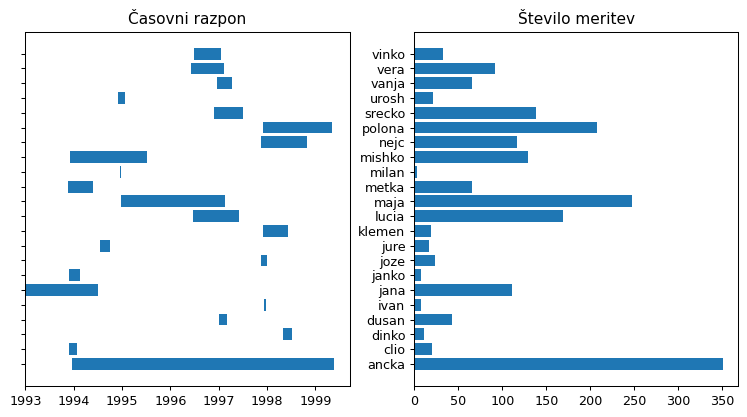

Oba sta `barh`. Z desnim ne bi smelo biti posebnih težav. Levi je bolj zanimiv. Črte tečejo od minimalnega do maksimalnega dneva; to dosežemo z argumentom `left`, kot dolžino pa podamo razliko med `min` in `max` (točno to, kar vrača `razpon`). Za nastavljanje številk na osebh uporabimo `xticks`. Predlagam, da se potrudiš z desnim grafom, levega pa pokažem na predavanjih, če bo čas.

#### Rešitev

Narisati le desni graf je preprosto.

<BarContainer object of 22 artists>

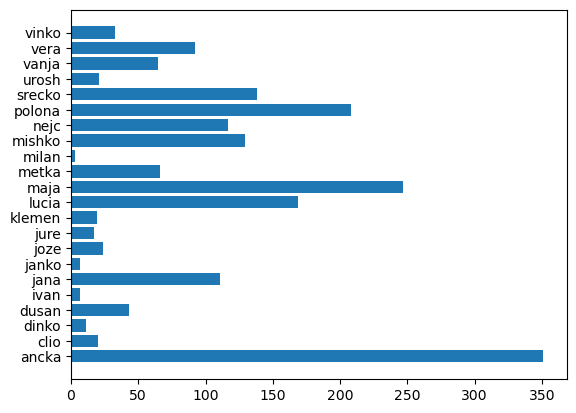

In [11]:
import matplotlib.pyplot as plt

uniimena, meritev = np.unique(imena, return_counts=True)

plt.barh(uniimena, meritev)

Levi je bolj zapleten.

([<matplotlib.axis.XTick at 0x1134d1f50>,
 [Text(0, 0, '1993'),
  Text(365, 0, '1994'),
  Text(730, 0, '1995'),
  Text(1095, 0, '1996'),
  Text(1461, 0, '1997'),
  Text(1826, 0, '1998'),
  Text(2191, 0, '1999'),
  Text(2556, 0, '2000')])

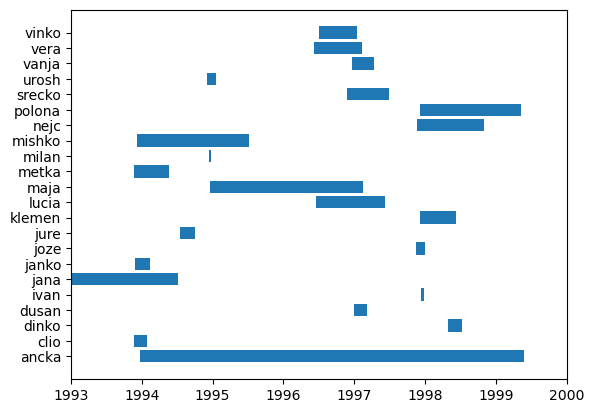

In [12]:
rmin = np.array([np.min(dnevi[imena == medved]) for medved in uniimena])
rmax = np.array([np.max(dnevi[imena == medved]) for medved in uniimena])

plt.barh(uniimena, rmax - rmin, left=rmin)
plt.xticks([(datetime(i, 1, 1) - datetime(1993, 1, 1)).days for i in range(1993, 2001)],
           [str(i) for i in range(1993, 2001)])

`rmin` in `rmax` sta prva in zadnja meritev za vsakega medveda.

`barh` podamo imena, dolžine črt (`rmax - rmin`) in koliko jih je potrebno odmakniti od levega roba (`rmin`).

Z `xticks` smo določili položaj (prvi argument) in vsebino oznak na osi `x`. Položaj je preprosto število dni od 1. januarja 1993 do 1. januarja posameznega leta; vsebina oznake pa je leto, pretvorjeno v niz.

Takole pa narišemo oba grafa enega ob drugem - natančno kot na gornji sliki.

Text(0.5, 1.0, 'Časovni razpon')

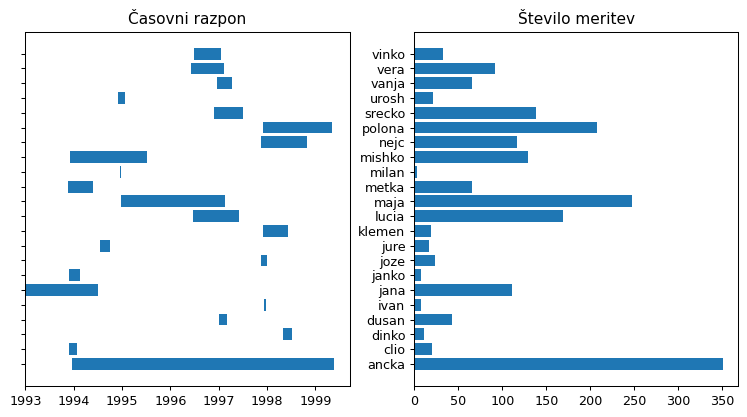

In [13]:
import matplotlib.pyplot as plt

uniimena, meritev = np.unique(imena, return_counts=True)
rmin = np.array([np.min(dnevi[imena == medved]) for medved in uniimena])
rmax = np.array([np.max(dnevi[imena == medved]) for medved in uniimena])

plt.figure(figsize=(10, 5), dpi=92)

ax1 = plt.subplot(122)
ax1.barh(uniimena, meritev)
ax1.set_title("Število meritev")

ax2 = plt.subplot(121, sharey=ax1)
plt.xticks([(datetime(i, 1, 1) - datetime(1993, 1, 1)).days for i in range(1993, 2001)],
           [str(i) for i in range(1993, 2001)])
plt.tick_params('y', labelleft=False)
ax2.barh(uniimena, rmax - rmin, left=rmin)
ax2.set_title("Časovni razpon")

S `plt.figure` smo določili velikost slike (v palcih) in ločljivost. Od tega je odvisna tudi privzeta velikost črk. S tem se je potrebno pač malo poigrati, da dobimo primerno razmerje.

`ax1` in `ax2` bosta sliki znotraj slike. Ko sestavimo `ax2` povemo, da si bo delila os `y` z `ax1`.

S `plt.tick_params('y', labelleft=False)` skrijemo oznake na levi osi levega grafa.

## Ocena 7: *Z zakrivljeno palico v roki* (pohaja medved *za tropom ovčic*)

Najbolj zanimive so meritve v dveh zaporednih dnevih - torej, ko so nekega medveda videli na primer, 13. maja in potem 14. maja.

**Pazi:** v fake-data.csv se datuma 2001-01-03 in 2001-01-04 ne nanašata na istega medveda, torej ne gre za zaporedno meritev!

- `n_zaporednih_meritev(medved)` prejme ime medved in pove, kolikokrat se je zgodilo, da je za medveda zabeležena pozicija na dva zaporedna dneva. (Recimo: koliko je takšnih dni, za katere velja, da so taistega medveda videli tudi dan predtem.) 
- `zaporedne_meritve()` vrne slovar, katerega ključi so imena medvedov, pripadajoče vrednost pa število zaporednih meritev za te medvede.
- `dnevna_razdalja(medved)` vrne povprečno dnevno razdaljo, ki jo je prehodil medved. Izračunamo jo tako, da za vse dneve, za katere obstajajo zaporedne meritve, izračunamo razdaljo med izmerjenima koordinata. Funkcija vrne povprečje teh razdalj. Če za kakega medveda ni zaporednih meritev, naj funkcija vrne `np.nan` oz. `math.nan`.
- `dnevne_razdalje()` vrne slovar, katerega ključi so medvedi, pripadajoče vrednosti pa njihove povprečne dnevne razdalje.
- `popotnik()` vrne ime medveda z največjo povprečno dnevno razdaljo.
- `izlet()` poišče največjo dnevno razdaljo (torej: par najbolj oddaljenih pozicij izmerjenih na zaporedna dneva za istega medvega). Vrniti mora trojko: ime medveda, ki je opravil tako pot, datum potovanja (drugi dan, ne prvi) in pretacano razdaljo. Datum je lahko shranjen kot Pythonov seznam s tremi elementi ali ekvivalentna tabela v numpyju.

<small>Opomba: dnevne razdalje so seveda podcenjene. Pravilne bi bile, če bi šel medved po tem, ko mu odčitajo pozicijo, v ravni črti na točko, kjer bi mu odčitali pozicijo prihodnji dan. To seveda ni nujno res, saj gre vmes mogoče še na stranišče ali pa strašit kolesarje.</small>

Naloge se lahko lotite po starem ali, vendar za vajo priporočam, da `n_zaporednih_meritev`, `dnevna_razdalja` in `izlet` sprogramirate z numpy (ali celo z in brez). Pri ostalih funkcijah numpy nima smisla, saj delajo le s kratkimi slovarji.

- Ta naloga je ena velika vaja iz mask, ki jih včasih le seštevamo, včasih pa očitno bo potrebno uporabljati maske in `np.sum`.
- `np.sqrt(a)` vrne tabelo s koreni vseh elementov v `a`.
- `np.mean(a)` vrne povprečno vrednost v tabeli `a`. Funkcija sprejme tudi `axis`, vendar tega tu ne potrebujemo.

Tudi tu lahko za neobvezno vajo dorišeš kak graf, recimo `bar` ali `barh` z dnevno razdaljo, ki jo prehodi medved.

### Rešitev

#### `n_zaporednih_meritev`

Najprej rešitev z `numpy`. Izberemo dneve, ki govorijo o podanm medvedu, `dnevi(imena == medved)`. Nato odštejemo zaporedne elemente in preverimo, ali je razlika enaka 1. Razultat bo tabela `True`-jev in `False`-ov. Zanima nas, koliko je `True`-jev, torej jo preprosto sešetejemo.

In [14]:
def n_zaporednih_meritev(medved):
    znani = dnevi[imena == medved]
    return np.sum(znani[1:] - znani[:-1] == 1)

Zdaj pa brez `numpy`-ja. Z indeksom `i` gremo prek celotne tabele. Če `i`-ti in `i + 1`-vi element `imena` pravita, da se vrstica nanaša na podanega medveda in če se `i`-ti in `i + 1`-vi dan nanašata na zaporedna dneva, imamo eno meritev več.

In [15]:
def n_zaporednih_meritev(medved):
    zaporednih = 0
    for i in range(len(dnevi) - 1):
        if imena[i] == imena[i + 1] == medved and dnevi[i + 1] - dnevi[i] == 1:
            zaporednih += 1
    return zaporednih

Krajše lahko to zapišemo v obliki, ki že skoraj spominja na `numpy`.

In [16]:
def n_zaporednih_meritev(medved):
    return sum(imena[i] == imena[i + 1] == medved and dnevi[i + 1] - dnevi[i] == 1
               for i in range(len(dnevi) - 1))

Čeprav je ta, zadnja različica kratka, bo tista v `numpy`-ju vseeno bistveno hitrejša. Res pa se bo razlika poznala šele, ko bomo imeli res veliko podatkov.

#### `zaporedne_meritve`

Tule le sestavimo slovar. Na počasi ali na hitro, kot v spodnji funkciji.

In [17]:
def zaporedne_meritve():
    return {medved: n_zaporednih_meritev(medved) for medved in medvedi()}

#### `dnevna_razdalja`

Tule gre spet predvsem za sestavljanje mask. S `ta_medved = imena == medved` dobimo masko, ki vsebuje `True` se vse vrstice, ki se nanašajo na tega medveda. To masko (brez zadnjega elementa) združimo z zamaknjeno masko, takšno brez prvega. Tako dobimo `True` v vseh vrsticah, za katere velja, da se tudi naslednja vrstica nanaša na tega istega medveda. Poleg tega z `dnevi[1:] - dnevi[:-1]` izračunamo razliko med zaporednimi elementi v `dnevi`. Z `== 1` poberemo tiste, pri katerih je ta razlika enaka `1`. Tako dobimo masko, ki ima `True` za vse prve vrstice izmed vrstic, ki se nanašajo na tega medveda in merijo zaporedne dneve.

Koordinate teh vrstic dobimo z `xy[:-1][maska]` (zadnji element moramo odbiti, ker je maska za en element krajša), koordinate naslednjih pa z `xy[1:][maska]` (s tem, ko odbijemo prvi element, poberemo ravno naslednje vrstice). Od druge odštejemo prvo. To kvadriramo, seštejemo po prvi osi in korenimo, pa dobimo vse dnevne razdalje. Vrniti moramo njihovo povprečje.

In [18]:
def dnevna_razdalja(medved):
    ta_medved = imena == medved
    maska = ta_medved[:-1] & ta_medved[1:] & (dnevi[1:] - dnevi[:-1] == 1)
    return np.mean(np.sqrt(np.sum((xy[1:][maska] - xy[:-1][maska]) ** 2, axis=1)))

Takole pa to storimo brez numpyja.

In [19]:
def dnevna_razdalja(medved):
    danp = 0
    raz = 0
    n = 0
    for ime, dan, koo in zip(imena, dnevi, xy):
        if dan == danp + 1 and imep == ime == medved:
            x0, y0 = koo
            x1, y1 = koop
            raz += np.sqrt((x0 - x1) ** 2 + (y0 - y1) ** 2)
            n += 1
        imep, danp, koop = ime, dan, koo
    return raz / n if n else np.nan

V `danp` si zapomnimo prejšnji dan, v `imep` in `koop` pra prajšnji koordinati. V pogoju znotraj zanke preverimo, ali imamo opravka s pravim medvedom in zaporednimi dnevi. Če je tako, razpakiramo koordinate in izračunamo razdaljo. To prištejemo k vsoti razdalj, v `n` pa štejemo, koliko takšnih meritev imamo.

Na koncu vrnemo povprečno razdaljo ali `np.nan`, če je `n` enak nič (in torej neresničen).

#### `dnevne_razdalje`

Funkcija `dnevne_razdalje` spet le sestavi slovar. Na hitro, kot kot spodaj, ali počasneje. Kakor zmoremo in znamo.

In [20]:
def dnevne_razdalje():
    return {medved: dnevna_razdalja(medved) for medved in medvedi()}

#### `popotnik`

Ključ, ki pripada največjemu elementu slovarja, menda znamo poiskati. Tule je rokohitrska rešitev.

In [21]:
def popotnik():
    razd = dnevne_razdalje()
    return max((k for k, v in razd.items() if not np.isnan(v)), key=razd.get)

#### `izlet`

Z  `imena[1:] == imena[:-1]` poiščemo zaporedne vrstice, ki se nanašajo na istega medveda in z `dnevi[1:] - dnevi[:-1] == 1` zaporedne vrstice, ki se nanašajo na zaporedna datuma.

Nato izračunamo tabelo razdalj na enak način kot v `dnevna_razdalja`.

Namesto povprečne vrednosti nas tu zanima največja, točneje, indeks največje vrednosti. Najdaljša razdalja je v `razdalje[i]`. Past pa je v tem, da imena in datuma ne smemo prebrati iz `imena[i]` in `datumi[i]`. Indeks `i` se namreč nanaša na `razdalje`, izračunane iz filtriranega `xy` - takšnega, v katerem smo izpustili vse vrstice, ki se ne nanašajo na istega medveda ali zaporedne dni. Zato je potrebno tabeli `imena` in `datumi` spustiti skozi masko, preden ju indeksiramo z `i`. Ker je maska za en element krajša, bo potrebno en element odbiti. Pri imenih bi bilo vseeno, ali odbijemo prvega ali zadnjega. Pri datumih odbijemo prvi datum v tabeli, da jo zamaknemo za en element; tako se bo na `i` tem mestu znašel drugi dan, tisti, na katerega je medved končal izlet -- kot zahteva naloga.

In [22]:
def izlet():
    maska = (imena[1:] == imena[:-1]) & (dnevi[1:] - dnevi[:-1] == 1)
    razdalje = np.sqrt(np.sum((xy[1:][maska] - xy[:-1][maska]) ** 2, axis=1))
    i = np.argmax(razdalje)
    return imena[1:][maska][i], datumi[1:][maska][i], razdalje[i]

## Ocena 8: Zimsko spanje

- Napiši funkcijo `mesecna_razdalja`, ki vrne tabelo ali seznam z 12 elementi, ki vsebujejo povprečno dnevno razdaljo, ki jo medvedi prehodijo v posameznem mesecu. Pri računanju torej upoštevaš razdalje med lokacijami, zabeleženi na zaporednih dneh za istega medveda. Če gre za meritev med, na primer, 31. januarjem in 1. februarjem, jo beleži pod februar.

    Če za kak mesec sploh ni zaporednih meritev (to se zgodi v lažnih podatkih), naj bo na pripadajočem mestu `np.nan`.

- Napiši funkcijo `leni_meseci(s)`, ki prejme seznam(!)) z povprečnimi dnevnimi razdaljami po mesecih. Poiskati trimesečno obdobje, v katerem je vsota dnevnih povprečij najmanjša in vrniti indeks prvega meseca tega obdobja. Upoštevaj, da bo vsaj do konca sveta vsakemu decembru sledil januar.

    Če je enako najbolj lenih obdobij več, vrni začetek prvega od njih.

    Predpostaviti smeš, da podatek za noben mesec ni `np.nan`.

    Klic `leni_meseci([5, 3, 5, 1, 2, 0, 3, 4, 1, 6, 1, 5])` vrne `4`, ker se leno obdobje (1, 2, 0) začne pri aprilu.

    Klic za resnične podatke vrne 12, ker medvedi lenarijo od decembra do februarja.

- Napiši funkcijo `lenoba(s)`, ki prejme enak argument kot prejšnja funkcija in vrne razmerje med povprečno dnevno razdaljo v lenih mesecih in povprečno dnevno razdaljo čez vse leto.

**Nasveti**:

- v `mesecna_razdalja` se splača kombinirati numpy (maske za imena medvedov in zaporedne dneve, računanje razdalj) ter zanke v Pythonu. Konkretno, v nekem trenutku bo najbrž potrebno narediti zanko čez vse zaporedne dnevne meritve. Lahko pa narediš tudi zanko čez vse podatke, če ti je lažje.
- Trik: mogoče se bo kdaj splačalo napisati `s + s`. Na ta način se bo januar znašel (tudi) za decembrom,
- Z nekaj iznajdljivosti se drugo funkcijo elegantno reši z `np.cumsum`. Če ti ne potegne, kako, pa naredi v čistem Pythonu. Tretjo pa itak.

### Rešitev

#### `mesecna_razdalja`

Najbolj (no, ne najbolj, pač pa dokaj) `numpy`-jevska rešitev je, da najprej pripravimo tabelo `mesecno`, ki ima toliko vrstic, kolikor je mesecev (12) in dva stolpca. V prvem stolpcu bo vsota mesečnih razdalj, v drugem število meritev za ta mesec.

Sstavimo si običajno masko, ki preveri, da gre za istega medveda in zaporedne dni. Potem izračunamo razdalje. To že znamo. Nato v `mesec` zapišemo mesec, v katerem je medved opravil to pot: datumom odbijemo zadnji element (`datumi[:-1]`), da jih lahko spustimo skozi masko `datumi[:-1][maska]` in nato vzamemo prvi stolpec, ki vsebuje `mesec`.

Gremo z zanko prek mesecev in razdalij. (Zato je rešitev samo "dokaj" numpyjevska - tule imamo Pythonovo zanko, ki gre prek kar dolgih tabel. Vendar bi si tule res zapletli življenje, če bi poskušali narediti drugače.) V tabelo `mesecno` v vrstico `m - 1`, ki se nanaša na `m`-ti mesec, prištejemo `[r, 1]` - torej k prvemu elementu prištejemo razdaljo, k drugemu, preprosto 1.

Na koncu vrnemo povprečne razdalje, ki ju dobimo tako, da delimo prvi stolpec z drugim.

In [23]:
def mesecna_razdalja():
    mesecno = np.zeros((12, 2))
    maska = (imena[1:] == imena[:-1]) & ((dnevi[1:] - dnevi[:-1]) == 1)
    razdalja = np.sqrt(np.sum((xy[1:] - xy[:-1])[maska]**2, axis=1))
    mesec = datumi[:-1][maska][:, 1]
    for m, r in zip(mesec, razdalja):
        mesecno[m - 1] += [r, 1]
    return mesecno[:, 0] / mesecno[:, 1]

#### `leni_meseci`

Najprej nerodna rešitev v čistem Pythonu.

In [24]:
def leni_meseci(s):
    naj_raz = None
    for mesec in range(12):
        raz = sum(s[mesec:mesec + 3])
        if mesec > 9:
            raz += sum(s[:mesec - 9])
        if naj_raz == None or raz < naj_raz:
            naj_raz = raz
            naj_mesec = mesec
    return 1 + naj_mesec

Razdalja, ki jo medved prehodi v treh mesecih, začenši z `mesec`, je, načelno `sum(s[mesec:mesec + 3])`. Zoprninja pa je v tem, da decembru sledi januar. Zato moramo k mesecem od `mesec == 9` naprej (to je oktober!) prišteti še določeno število prvih mesecev. Ostanek je potem preprost.

Delo si poenostavimo tako, da seznam podvojimo: namesto `s[mesec:mesec + 3]` seštevamo `(s + s)[mesec:mesec + 3]`. Tako dodamo januar, februar (in še ostalih deset mesecev) na konec.

In [25]:
def leni_meseci(s):
    naj_raz = None
    for mesec in range(12):
        raz = sum((s + s)[mesec:mesec + 3])
        if naj_raz == None or raz < naj_raz:
            naj_raz = raz
            naj_mesec = mesec
    return 1 + naj_mesec

Rokohitrska različica istega (še vedno v čistem Pythonu) je

In [26]:
def leni_meseci(s):
    return 1 + min((i for i in range(12)), key=lambda j: sum((s * 2)[j: j + 3]))

V `numpy` nalogo uženemo zelo preprosto, če se znajdemo.

Funkcija `cumsum` vrne kumulativno vsoto. Sešteti ji damo `[0] + s`, pa bo sestavila tabelo, ki se bo začela z 0, potem pa bo v vsakem elementu zapisano, koliko je medved prehodil od začetka leta do posamičnega meseca.

In [27]:
s = [5, 2, 1, 13]
np.cumsum([0] + s)

array([ 0,  5,  7,  8, 21])

Če odštejemo n-ti element od n+3-tega, bomo izvedeli, koliko je prehodil v času med n-tim in n+3-tim mesecem.

In [1]:
def leni_meseci(s):
    s = np.cumsum([0] + list(s) * 2)
    return 1 + np.argmin(s[3:] - s[:-3])

Paziti moramo na tole: če je `s` pythonov seznam, dodamo še eno kopijo elementov s `s + s` ali `s * 2`. Če je `s` numpyjeva tabela, pa bi gornje podvojilo vrednosti elementov. Zato ga bodisi pretvorimo v seznam in potem podvojimo, `list(s) * s`, bodisi ga sestavimo v novo tabelo, recimo z `np.hstack((s, s))`.

#### `lenoba`

Polkičemo lene mesece, da izvemo, kdaj je medved začel lenariti, `leni = leni_meseci(s) - 1`. `1` je potrebno odšteti, ker `leni_meseci` označi prvi mesec z `1`, v tabeli pa je to `0`-ti element.

Potem izračunamo povprečje za obdbobje od `(s + s)[leni:leni + 3]` in ga delimo s celoletnim povprečjem.

In [29]:
def lenoba(s):
    leni = leni_meseci(s) - 1
    return np.mean((s + s)[leni:leni + 3]) / np.mean(s)

Rešitev v Pythonu je podobna, le da uporabimo `sum` in sami delimo s številom mesecev.

### Neobvezni del

Kdor hoče malo vaje iz grafov, bo še graf, ki kaže povprečne mesečne razdalje.

#### Rešitev

<BarContainer object of 12 artists>

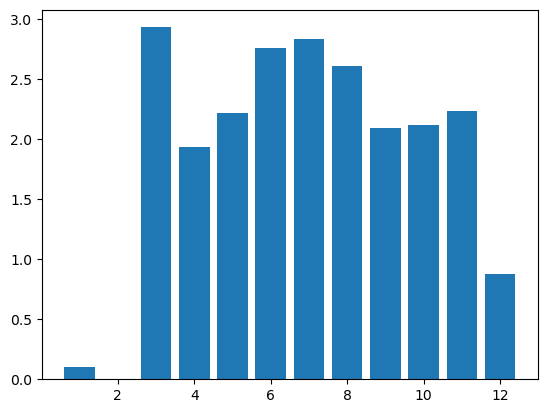

In [30]:
plt.bar(np.arange(1, 13), mesecna_razdalja())

## Ocena 9: *Amigos para siempre*

Napiši naslednje funkcije.

- `povprecna_razdalja(medved1, medved2)` vrne povprečno razdaljo med vsemi pari točk, na katerih so opazili medveda s podanima imenoma.
- `povprecne_razdalje()` vrne slovar, katerega ključi so vsi pari imen medvedov (na primer `("ancka", "jana")`), pripadajoče vrednosti pa razdalje med tema medvedoma. Vsak par naj se pojavi le enkrat: pare sestavi tako, da bo prvo ime po abecedi pred drugim.
- `prijatelji()` izpiše deset parov (ali manj, če ni toliko medvedov) z najmanjšo razdaljo. Spisek naj bo urejen po naraščajočih razdaljah in naj bo oblikovan do presledka natančno tako (število ima 5 mest, od tega dve decimalni; na koncu vrstice ni "nevidnih" presledkov za imeni!):

```python
               dusan :  2.88 : vanja
               vanja :  2.96 : vera
                maja :  3.22 : vanja
               dusan :  3.39 : vera
               dusan :  3.63 : maja
               lucia :  3.73 : vanja
                maja :  3.76 : vera
                clio :  3.89 : lucia
                clio :  3.94 : vanja
               lucia :  4.04 : vera
```

- `bffl()` vrne najboljša prijatelja. V gornjem primeru sta to Dušan in Vanja. (Opomba: brez namigovanj. Poiskal sem članek: gre za enoletnega medvedka in medvedko.)

**Nasvet:**

- `povprecne_razdalje()` se bo izvajala par sekund; funkcija, ki je dejansko pocasna je `povprecna_razdalja`. Pri njej se ti **res splača** nabrati vse koordinate obeh medvedov z numpyjem in maskami. Potem pa pozabi na numpy in napiši dve zanki v Pythonu.

    Rešitev z uporabo numpyja je stokrat hitrejša (in bistveno krajša), vendar zahteva malo več znanja. Ta, ki ga zanima, naj se zazre v tole in in potem razmisli, kako mu to pomaga. Namig: tole je potem potrebno narediti s koordinatama ločeno.

    ```
    >>> np.array([1, 2, 3]) + np.array([[100], [200]])
    array([[101, 102, 103],
           [201, 202, 203]])
    >>> a = np.array([100, 200])
    >>> a[:, None]
    array([[100],
           [200]])
    ```

- Pri ostalih funkcijah nimate kaj početi z numpyjem.

### Rešitev

#### `povprecna_razdalja`

Nalogo najprej rešimo s kombinacijo Pythona in numpyja (kdor bi hotel čisti Python, bo pač moral preverjati še imena medvedov).

In [31]:
def povprecna_razdalja(medved1, medved2):
    d = 0
    xy1 = xy[imena == medved1]
    xy2 = xy[imena == medved2]
    for xa, ya in xy1:
        for xj, yj in xy2:
            d += np.sqrt((xa - xj) ** 2 + (ya - yj) ** 2)
    return d / (len(xy1) * len(xy2))

Funkcija iz `xy` najprej pobere vse podatke za enega in drugega medveda. Nato gre prek vseh parov, sešteva razdalje in na koncu vrne vsoto, deljeno s številom parov. Nobena znanost.

Rešitev v čistem `numpy`-ju pa *je* kar znanost.

In [32]:
def povprecna_razdalja(medved1, medved2):
    xy1 = xy[imena == medved1]
    xy2 = xy[imena == medved2]
    return np.mean(np.sqrt((xy1[:, 0] - xy2[:, 0, None]) ** 2 + (xy1[:, 1] - xy2[:, 1, None]) ** 2))

`xy1[: 0]` je koordinata x prvega medveda; matrika ima dimenzijo `n`; lahko si jo predstavljamo kot vrstico z n-elementi. `xy2[:, 0]` bi bilo isto za drugega medveda. Z `, None` dodamo novo os; to spremeni vrstico v stolpec. Vrstico za prvega medveda in stolpec za drugega odštejemo. Tako dobimo dvodimenzionalno tabelo z vsemi pari razlik.

Poglejmo primer.

In [33]:
a = np.array([3, 5, 9])
b = np.array([2, 5, 4])

To sta vrstici. Na `b` poglejmo kot na stolpec:

In [34]:
b[:, None]

array([[2],
       [5],
       [4]])

Odštejmo vrstico `a` in postolpčnjeni `b`.

In [35]:
a - b[:, None]

array([[ 1,  3,  7],
       [-2,  0,  4],
       [-1,  1,  5]])

Kaj vsebujejo vrstice razlike? `a`, od katerega odštevamo posamezne elemente `b`-ja.

In [36]:
a - 2

array([1, 3, 7])

In [37]:
a - 5

array([-2,  0,  4])

In [38]:
a - 4

array([-1,  1,  5])

Enako torej storimo z `x` koordinatama medvedov. Koordinate drugega obrnemo v stolpec, odštejemo. Vse, kar je v tabeli skvadriramo - tako dobimo kvadrate razlik `x`. Enako storimo s koordinato `y`. Tabeli kvadriranih razlik x in y seštejemo, vsote korenimo in potem pa izračunamo povprečje vsega skupaj.

Nisem rekel, da ni znanost. To je najbrž najnaprednejša koda v numpy-ju, kar ste je in jo boste videli pri predmetu.

#### `povprecne_razdalje`, `prijatelji`, `bffl`

Vse ostalo je v primerjavi s tem trivialno.

In [39]:
def povprecne_razdalje():
    return {(medved1, medved2): povprecna_razdalja(medved1, medved2)
            for medved1 in medvedi() for medved2 in medvedi()
            if medved1 < medved2}

def prijatelji():
    for r, (med1, med2) in sorted((v, k) for k, v in povprecne_razdalje().items())[:10]:
        print(f"{med1:>20} : {r:5.3} : {med2}")

def bffl():
    razdalje = povprecne_razdalje()
    return min(razdalje, key=razdalje.get)

## Ocena 10: Medvedi na obisku

V zadnjih funkcijah bomo preverili, kako družabni so medvedi in kam zahajajo medvedi, ko se jim zahoče človeške družbe. Funkcije bodo prejele seznam koordinat krajev, na primer `[[45.962375, 14.293736], [45.916703, 14.229728], [45.775864, 14.213661], [45.9709794, 14.1118016]]` (koordinati "središč" Vrhnike, Logatca, Postojne in Cerknice).

Pazi, koordinate bo potrebno iz zemljepisne širine in dolžine pretvoriti v koordinatni sistem s središčem v Medvedjem Brdu, kot to počnemo v prvi funkciji za oceno 6.

- `druzabnost(medved, kraji, k)` vrne število meritev, v katerih je bil podani medved največ `k` kilometrov daleč od enega od podanih krajev.
- `tezisce_delovanja(medved, kraji)` za vsako meritev ugotovi, kateremu izmed krajev je najbližje. Vrniti mora tabelo ali seznam, ki ima toliko elementov kolikor je krajev; vsak element vsebuje delež primerov, ko je bil medved najbližje temu kraju.

    Klic `tezisce_delovanja("maja", kraji)` vrne `[0.59, 0.31, 0, 0.1]`, ker je bila Maja v 59 % primerov najbližje Vrhniki, v 31 % najbližje Logatcu, nikoli najbližje Postojni in v 10 % primerov najbližje Cerknici. Klic `tezisce_delovanja("polona", kraji)` pa vrne `[0, 0, 0, 1]`. Polona je Cerkničanka.
- `obiskovalci(kraji)` prejme seznam krajev in vrne seznam množic. Za vsakega medveda pogleda, kateremu kraju je najpogosteje nejbližje. Če prvemu, da doda v prvo množico; če drugemu v drugo in tako naprej.

**Nasveti**

- V teh funkcijah zdravo mešaj numpy in Pythonove zanke. Te bodo šle vedno čez kraje ali čez medvede.
- Pazi, da ne boš slučajno pretvoril v medvedji koordinatni sistem koordinat, ki so morda že v medvedjem koordinatnem sistemu.
- Najlepša (z vidika numpyja) je `tezisce_delovanja`: spomni se na `np.unique` in na to, da lahko funkciji `np.argmin` lahko podaš os.

### Rešitev

#### `druzabnost`

Seznam s koordinatami krajev pretvorimo v tabelo v numpyju, da jih lahko damo funkciji `pretvori_koordinate`.

Nato izberemo koordinate podanega medveda.

Pripravimo si tabelo `blizu`, ki bo za vsake koordinate, na katerih so zalotili medveda, povedala ali je blizu enemu od podanih krajev.  Če bi imeli le pet koordinat, bi bila začetna vrednost tabele `[False, False, False, False, False]`.

Sledi zanka v Pythonu, ki bo šla prek krajev. Krajev ne bo veliko, torej ni hudo, da delamo zanko prek njih v čistem Pythonu. `kraj` bodo torej koordinate posamičnih krajev.

Za vse koordinate izračunamo, kako daleč je od koordinat `kraj`: `np.sqrt(np.sum((koord - kraj) ** 2, axis=1))`. Razdaljo primerjamo s `k`. Tako dobimo masko: dolga je toliko, kolikor je koordinat in za vsako pripadajočo koordinato vsebuje `True`, če je kraju `kraj` bližje kot `k`. 
- Recimo, da so prvemu kraju blizu druga in tretja koordinate. V tem primeru bo `np.sqrt(np.sum((koord - kraj) ** 2, axis=1)) <= k` enak `[False, False, True, True, False]`. Z `blizu |= np.sqrt(np.sum((koord - kraj) ** 2, axis=1)) <= k` se bo `blizu` torej spremenil v `[False, False, True, True, False]`.
- Recimo, da so drugemu kraju blizu ničta in druga koordinata. Primerjanje s `k` bo dalo `[True, False, True, False, False`]. Z `blizu |= ...` bomo na `True` postavili ničto in drugo (ki je bila pravzaprav že `True`) in tako dobili `[True, False, True, True, False]`.
- Tako nadaljujemo za vse kraje.

Na koncu bo `blizu` vsebovala `True` za vse koordinate, ki so bile vsaj enemu od krajev bližje kot `k`. Ostane nam le še, da preštejemo, koliko `True`-jev je v tabeli.

In [40]:
def druzabnost(medved, kraji, k):
    kraji = np.array(kraji)
    pretvori_koordinate(kraji)
    koord = xy[imena == medved]
    blizu = np.zeros(len(koord), dtype=bool)
    for kraj in kraji:
        blizu |= np.sqrt(np.sum((koord - kraj) ** 2, axis=1)) <= k
    return np.sum(blizu)

#### `tezisce_delovanja`

Namesto `blizu` bomo imeli zdaj `razdalje`, ki bo imela toliko vrstic, kolikor je koordinat in toliko stolpec, kolikor je krajev. Vsak element bo povedal, kako daleč je posamična koordinata od posamičnega kraja.

Podobno kot prej imamo zanke čez kraje, le da zdaj ne računamo disjunkcije mask, temveč v i-ti stolpec vpišemo razdalje do i-tega kraja.

Zdaj moramo za vsako vrstico ugotoviti, v katerem stolpcu se nahaja njen najmanjši element - to je namreč številka kraja z najmanjšim stolpcev. To naredimo z `najblizji = np.argmin(razdalje, axis=1)`.

Potem je potrebno le še prešteti, kolikokrat se v `najblizji` pojavi kateri kraj. Za to lahko uporabimo kar zanko v Pythonu, ki gre prek indeksov krajev (`range(len(kraji))`), ter prešteje, kolikokrat je resničen pogoj `najblizji == i`. Krajev ni veliko, torej to ne bo prehudo. Spodaj, na koncu pa je vendarle še rešitev brez zanke. Da dobimo deleže, deli vsoto s številom koordinat.

In [41]:
def tezisce_delovanja(medved, kraji):
    kraji = np.array(kraji)
    pretvori_koordinate(kraji)
    koord = xy[imena == medved]
    razdalje = np.empty((len(koord), len(kraji)))
    for i, kraj in enumerate(kraji):
        razdalje[:, i] = np.sqrt(np.sum((koord - kraj) ** 2, axis=1))

    najblizji = np.argmin(razdalje, axis=1)

    tezisca = []
    for i in range(len(kraji)):
        tezisca.append(np.sum(najblizji == i) / len(koord))
    return tezisca

Pri zanki v Pythonu je moteče, da štejemo vsako ponovitev posebej. Lahko bi si pomagali s `Counter`.

In [42]:
def tezisce_delovanja(medved, kraji):
    kraji = np.array(kraji)
    pretvori_koordinate(kraji)
    koord = xy[imena == medved]
    razdalje = np.empty((len(koord), len(kraji)))
    for i, kraj in enumerate(kraji):
        razdalje[:, i] = np.sqrt(np.sum((koord - kraj) ** 2, axis=1))

    najblizji = np.argmin(razdalje, axis=1)
    stevci = Counter(najblizji)
    return [stevci[i] / len(koord) for i in range(len(kraji))]

Lahko pa uporabimo `np.unique`. Težava z njim je, da ne zagotavlja vrstnega reda krajev in, predvsem, da bo izpustil kraje, ki jim medved nikoli ni najbližje. Njegova uporaba je zato malo bolj zapletena:

In [43]:
def tezisce_delovanja(medved, kraji):
    kraji = np.array(kraji)
    pretvori_koordinate(kraji)
    koord = xy[imena == medved]
    razdalje = np.empty((len(koord), len(kraji)))
    for i, kraj in enumerate(kraji):
        razdalje[:, i] = np.sqrt(np.sum((koord - kraj) ** 2, axis=1))

    idx, cnt = np.unique(np.argmin(razdalje, axis=1), return_counts=True)
    stevci = np.zeros(len(kraji))
    stevci[idx] = cnt
    return stevci / np.sum(stevci)

`np.unique` vrne indekse krajev in pogostosti. Pripravimo si tabelo ničel in nato na ustrezna mesta zapišemo ustrezne števce.

Pa še rešitev brez zanke v Pythonu.

In [ ]:
def tezisce_delovanja(medved, kraji):
    kraji = np.array(kraji)
    pretvori_koordinate(kraji)
    koord = xy[imena == medved]
    razdalje = np.sqrt(np.sum((kraji - koord[:, None]) ** 2, axis=2))

    stevci = np.zeros(len(kraji))
    idx, cnt = np.unique(np.argmin(razdalje, axis=1), return_counts=True)
    stevci[idx] = cnt
    return stevci / np.sum(stevci)

#### `obiskovalci`

Tale bo kar v Pythonu.

Pripravimo seznam s toliko množicami, kolikor je krajev. Za vsakega medveda pokličemo težišče delovanja, z `np.argmax` izvemo indeks kraja, kjer je bil največkrat in medveda dodamo v pripadajočo množico.

In [44]:
def obiskovalci(kraji):
    patroni = [set() for _ in kraji]
    for medved in imena:
        patroni[np.argmax(tezisce_delovanja(medved, kraji))].add(medved)
    return patroni

### Neobvezni del

Študenti z močnejšim statističnim ozadjem lahko poskusijo narisati tole.

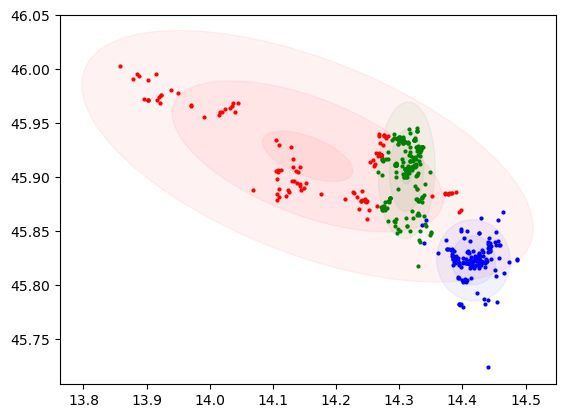

Slika se nanaša na Jano (rdeča), Polono (modra) in Majo (zelena). Graf je vrste `scatter`, z `add_patch` pa so dodane elipse. Njihovo središče je v povprečni koordinati medveda, osi gresta v smereh lastnih vektorjev, polmeri pa so veliki 1, 3 in 5 deviacij. Z drugimi besedami, slika ilustrira dvodimenzionalno Gaussovo porazdelitev, izračunano iz opaženih koordinat medvedov.

#### Rešitev

Kot rečeno: močnejše statistično ozadje. Izračunati je potrebno kovariannčno matriko ter njene lastne vrednosti in vektorje. Z `add_patch` dodamo elipse z ustreznimi polmeri in pod ustreznim kotom.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


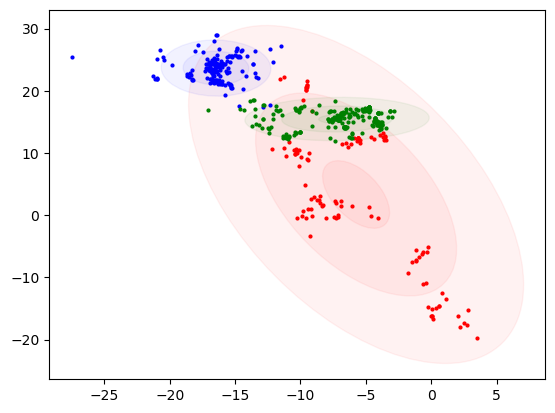

In [47]:
import math
import matplotlib

colors = ("red", "blue", "green")
bears = ("jana", "polona", "maja")

ax = plt.subplot()

for ime, col in zip(bears, colors):
    points = xy[imena==ime]
    mu = np.mean(points, axis=0)
    cov = np.cov(*(points - mu).T)
    vals, vects = np.linalg.eig(cov)
    for d in (1, 3, 5):
        ax.add_patch(matplotlib.patches.Ellipse(mu.T, *d*np.std(points, axis=0)[::-1], math.degrees(math.atan2(*vects[0])), color=col, alpha=0.05))
    
    
for ime, col in zip(bears, colors):
    points = xy[imena==ime]
    ax.scatter(*points.T, s=4, c=col)